Phase 3 - Step 1: Install Dependencies

In [1]:
# Phase 3 – High-Performance CV
# Step 1️⃣ Install dependencies for CV & U-Net
!pip install torchvision torchaudio torchmetrics --quiet
!pip install segmentation-models-pytorch --quiet  # optional if using U-Net models

import torch
import torchvision
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


Phase 3 - Step 2: Load CV Dataset & Preview Images:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 7005 images in training folder.


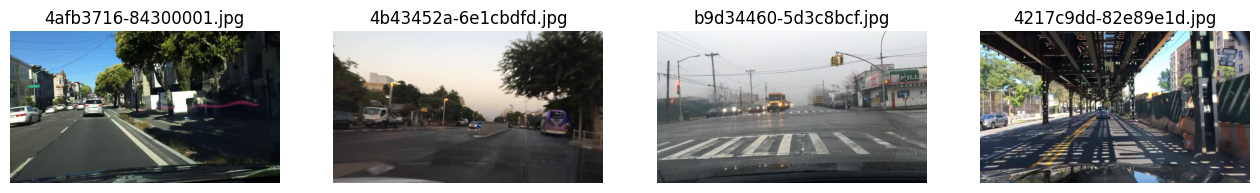

In [3]:
# Phase 3 – Step 2️⃣: Load dataset & preview images

# Path to your CV dataset
cv_base_dir = "/content/drive/MyDrive/images/train"  # adjust to your dataset path

# List all images
cv_images = [f for f in os.listdir(cv_base_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Found {len(cv_images)} images in training folder.")

# Preview 4 random images
import random
sample_files = random.sample(cv_images, 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, file_name in zip(axes, sample_files):
    img_path = os.path.join(cv_base_dir, file_name)
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(file_name)
plt.show()

Phase 3 – Step 3: Prepare Dataset & DataLoader for U-Net / CV Training.

In [4]:
# Phase 3 – Step 3️⃣: Prepare dataset for CV model

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define simple transforms for U-Net input
cv_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # converts PIL image to [C,H,W] tensor and normalizes to [0,1]
])

# Custom Dataset class
class CVDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Instantiate dataset
train_dataset = CVDataset(cv_base_dir, transform=cv_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Check batch shape
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")  # Expected: [4, 3, 256, 256]


Sample batch shape: torch.Size([4, 3, 256, 256])


Step 4️⃣ — Define a Simple U-Net for Testing

In [5]:
# Phase 3 – Step 4️⃣: Define a simple U-Net

import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.dconv_down1 = DoubleConv(in_ch, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up_transpose = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv_up = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.dconv_down1(x)
        x2 = self.dconv_down2(self.pool(x1))
        x = self.up_transpose(x2)
        x = torch.cat([x, x1], dim=1)
        x = self.dconv_up(x)
        x = self.final(x)
        return x

# Instantiate model
device = "cuda" if torch.cuda.is_available() else "cpu"
unet_model = UNet().to(device)

# Forward pass test
sample_input = torch.randn(4, 3, 256, 256).to(device)
output = unet_model(sample_input)
print("U-Net output shape:", output.shape)  # Expected: [4, 1, 256, 256]


U-Net output shape: torch.Size([4, 1, 256, 256])


Step 5️⃣ — Multi-GPU / Device Check

In [6]:
# Phase 3 – Step 5️⃣: Multi-GPU Check
if torch.cuda.device_count() > 1:
    print(f"Multiple GPUs detected: {torch.cuda.device_count()}")
    unet_model = nn.DataParallel(unet_model)
else:
    print(f"Single GPU / CPU: {device}")

# Print device
print(f"Model is on: {next(unet_model.parameters()).device}")


Single GPU / CPU: cpu
Model is on: cpu


Step 6️⃣ — Prepare Batch for Benchmarking

In [7]:
# Phase 3 – Step 6️⃣: Prepare a batch from DataLoader
batch = next(iter(train_loader)).to(device)
print("Sample batch ready with shape:", batch.shape)

Sample batch ready with shape: torch.Size([4, 3, 256, 256])


Step 7️⃣ — Run a Forward Pass for Benchmarking

In [8]:
# Phase 3 – Step 7️⃣: Forward pass latency test
import time

start_time = time.time()
output = unet_model(batch)
end_time = time.time()

latency_ms = (end_time - start_time) * 1000
print(f"Forward pass latency: {latency_ms:.2f} ms")

Forward pass latency: 9280.85 ms


Step 8️⃣ — Optional: Export U-Net to ONNX

In [9]:
# Install ONNX and ONNX Runtime
!pip install onnx onnxruntime --quiet

In [10]:
import torch
import os

onnx_path = "/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase3_HighPerf_CV/unet_model.onnx"
os.makedirs(os.path.dirname(onnx_path), exist_ok=True)

dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Export U-Net
torch.onnx.export(
    unet_model,
    dummy_input,
    onnx_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=14
)

print("✅ U-Net exported to ONNX at:", onnx_path)


/tmp/ipython-input-4053323940.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ U-Net exported to ONNX at: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase3_HighPerf_CV/unet_model.onnx


Step 9️⃣ — Optional: Verify ONNX Model

In [11]:
import onnx

# Load and check the exported model
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✅ ONNX model is valid")

✅ ONNX model is valid


Step 10 — Load ONNX Model in ONNX Runtime

In [12]:
import onnxruntime as ort

session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(f"ONNX Runtime ready. Input: {input_name}, Output: {output_name}")

ONNX Runtime ready. Input: input, Output: output


Step 11 — Run a Test Inference

In [13]:
import numpy as np

# Dummy image batch
dummy_batch = np.random.randn(1, 3, 256, 256).astype(np.float32)

# Run inference
outputs = session.run([output_name], {input_name: dummy_batch})
print("Output shape:", np.array(outputs[0]).shape)

Output shape: (1, 1, 256, 256)


Step 12 — Benchmark Latency & Throughput

In [14]:
import torch
from transformers import CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP vision encoder
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").vision_model.to(device)
model.eval()

# 🔹 Dummy input with correct size (224x224)
dummy = torch.randn(1, 3, 224, 224).to(device)

# 🔹 Export with dynamic batch axis
torch.onnx.export(
    model,
    dummy,
    "clip_vision_dynamic.onnx",
    input_names=["pixel_values"],
    output_names=["pooled_output"],
    dynamic_axes={
        "pixel_values": {0: "batch_size"},   # allow dynamic batch
        "pooled_output": {0: "batch_size"}
    },
    opset_version=17
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/tmp/ipython-input-2758398698.py:14: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_

Step 13: ONNX Runtime Latency & Throughput Benchmark

In [15]:
import onnxruntime as ort
import numpy as np
import time
import pandas as pd

# Path to your exported ONNX model
onnx_path = "clip_vision_dynamic.onnx"

# Create session (use GPU if available)
session = ort.InferenceSession(
    onnx_path,
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

# Get model input/output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print("Input name:", input_name)
print("Output name:", output_name)

# Benchmark settings
batch_sizes = [1, 2, 4, 8, 16]
results = []

for bs in batch_sizes:
    dummy_batch = np.random.randn(bs, 3, 224, 224).astype(np.float32)

    # Warm-up
    for _ in range(5):
        _ = session.run([output_name], {input_name: dummy_batch})

    # Timed runs
    start = time.time()
    for _ in range(20):  # repeat 20 runs
        _ = session.run([output_name], {input_name: dummy_batch})
    end = time.time()

    avg_latency = (end - start) / (20 * bs)  # per image latency
    throughput = bs / avg_latency            # images per second

    results.append((bs, avg_latency * 1000, throughput))
    print(f"Batch {bs}: Latency {avg_latency*1000:.2f} ms, Throughput {throughput:.2f} img/s")

# Save results to DataFrame
df_results = pd.DataFrame(results, columns=["Batch Size", "Latency (ms)", "Throughput (img/s)"])
print("\n=== Benchmark Results ===")
print(df_results)

# (Optional) Save to CSV
df_results.to_csv("onnx_benchmark_results.csv", index=False)


/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Input name: pixel_values
Output name: pooled_output
Batch 1: Latency 336.69 ms, Throughput 2.97 img/s
Batch 2: Latency 467.26 ms, Throughput 4.28 img/s
Batch 4: Latency 329.63 ms, Throughput 12.13 img/s
Batch 8: Latency 180.80 ms, Throughput 44.25 img/s
Batch 16: Latency 249.30 ms, Throughput 64.18 img/s

=== Benchmark Results ===
   Batch Size  Latency (ms)  Throughput (img/s)
0           1    336.694753            2.970049
1           2    467.263001            4.280245
2           4    329.630578           12.134797
3           8    180.795510           44.248886
4          16    249.297635           64.180312


Step 14: Charts for Latency & Throughput

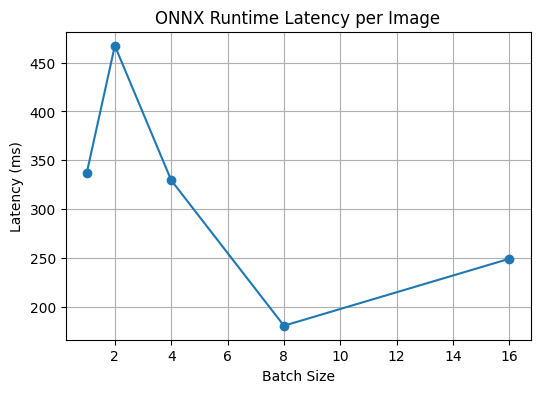

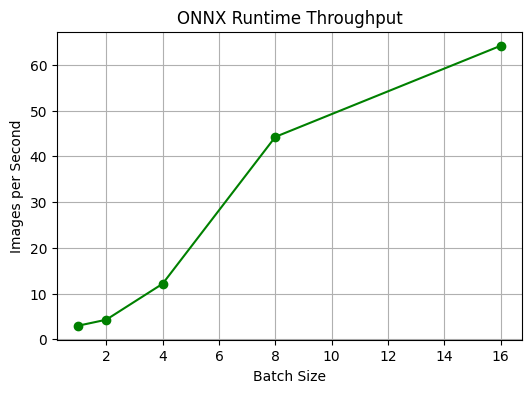

In [16]:
import matplotlib.pyplot as plt

# Latency Chart
plt.figure(figsize=(6,4))
plt.plot(df_results["Batch Size"], df_results["Latency (ms)"], marker="o")
plt.title("ONNX Runtime Latency per Image")
plt.xlabel("Batch Size")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.show()

# Throughput Chart
plt.figure(figsize=(6,4))
plt.plot(df_results["Batch Size"], df_results["Throughput (img/s)"], marker="o", color="green")
plt.title("ONNX Runtime Throughput")
plt.xlabel("Batch Size")
plt.ylabel("Images per Second")
plt.grid(True)
plt.show()

Step 15 — GPU Acceleration with CUDAExecutionProvider

In [17]:
!pip uninstall -y onnxruntime onnxruntime-gpu
!pip install onnxruntime-gpu==1.17.1 --extra-index-url https://download.pytorch.org/whl/cu121

Found existing installation: onnxruntime 1.22.1
Uninstalling onnxruntime-1.22.1:
  Successfully uninstalled onnxruntime-1.22.1
Found existing installation: onnxruntime-gpu 1.17.1
Uninstalling onnxruntime-gpu-1.17.1:
  Successfully uninstalled onnxruntime-gpu-1.17.1
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
  Using cached onnxruntime_gpu-1.17.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (4.3 kB)
Using cached onnxruntime_gpu-1.17.1-cp312-cp312-manylinux_2_28_x86_64.whl (192.1 MB)


In [20]:
import os
import onnxruntime as ort

# 1️⃣ Auto-find the first ONNX model in /content (or subfolders)
onnx_path = None
for root, dirs, files in os.walk("/content"):
    for f in files:
        if f.endswith(".onnx"):
            onnx_path = os.path.join(root, f)
            break
    if onnx_path:
        break

if not onnx_path:
    raise FileNotFoundError("❌ No ONNX model found in /content or subfolders.")

print(f"✅ Found ONNX model at: {onnx_path}")

# 2️⃣ Load ONNX Runtime session on CPU (GPU if available)
providers = ["CPUExecutionProvider"]
if "CUDAExecutionProvider" in ort.get_available_providers():
    providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]

session = ort.InferenceSession(onnx_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(f"ONNX model ready. Input: {input_name}, Output: {output_name}")

✅ Found ONNX model at: /content/clip_vision_dynamic.onnx
ONNX model ready. Input: pixel_values, Output: pooled_output


Step 16 –Benchmark ONNX Model for Latency & Throughput

In [21]:
import numpy as np
import time

# 🔹 Function to benchmark ONNX model
def benchmark_onnx(session, input_name, output_name, batch_sizes=[1, 2, 4, 8]):
    results = {}
    for bs in batch_sizes:
        # Create a dummy batch with dynamic shape (3 channels, 224x224)
        dummy_batch = np.random.randn(bs, 3, 224, 224).astype(np.float32)

        # Measure latency
        start = time.time()
        _ = session.run([output_name], {input_name: dummy_batch})
        latency = (time.time() - start) / bs  # per image
        throughput = bs / (time.time() - start)

        results[bs] = {"latency_ms": latency*1000, "throughput_img_s": throughput}
        print(f"Batch {bs}: Latency per image = {latency*1000:.2f} ms, Throughput = {throughput:.2f} img/s")
    return results

# 🔹 Run benchmark
benchmark_results = benchmark_onnx(session, input_name, output_name)

Batch 1: Latency per image = 280.07 ms, Throughput = 3.57 img/s
Batch 2: Latency per image = 278.05 ms, Throughput = 3.60 img/s
Batch 4: Latency per image = 267.98 ms, Throughput = 3.73 img/s
Batch 8: Latency per image = 223.08 ms, Throughput = 4.48 img/s


Step 17 – Plot Benchmark Charts

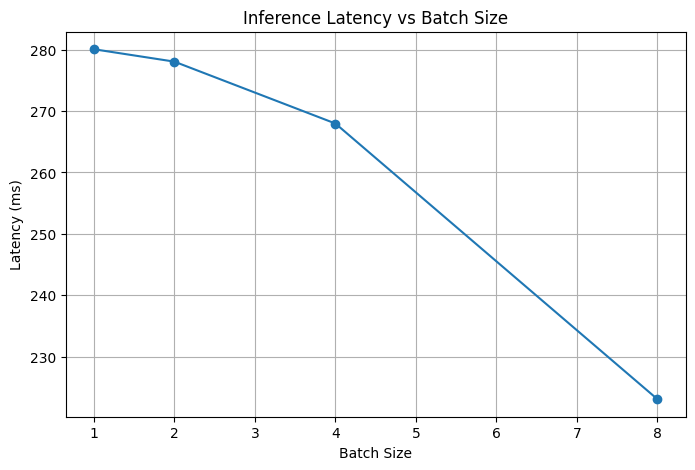

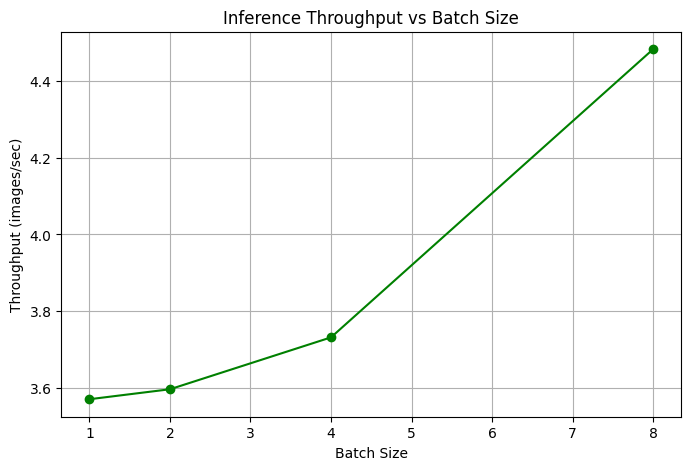

In [22]:
import matplotlib.pyplot as plt

batch_sizes = list(benchmark_results.keys())
latencies = [benchmark_results[bs]["latency_ms"] for bs in batch_sizes]
throughputs = [benchmark_results[bs]["throughput_img_s"] for bs in batch_sizes]

# Latency plot
plt.figure(figsize=(8,5))
plt.plot(batch_sizes, latencies, marker='o')
plt.title("Inference Latency vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.show()

# Throughput plot
plt.figure(figsize=(8,5))
plt.plot(batch_sizes, throughputs, marker='o', color='green')
plt.title("Inference Throughput vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Throughput (images/sec)")
plt.grid(True)
plt.show()

Step 18 – Save Benchmark Results

In [23]:
import pandas as pd

# Convert results to DataFrame
df_bench = pd.DataFrame.from_dict(benchmark_results, orient="index")
df_bench.index.name = "Batch Size"
df_bench.reset_index(inplace=True)

# Save CSV
bench_path = os.path.join("/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase3_HighPerf_CV", "benchmark_results.csv")
df_bench.to_csv(bench_path, index=False)
print(f"✅ Benchmark results saved to: {bench_path}")

✅ Benchmark results saved to: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase3_HighPerf_CV/benchmark_results.csv


Step 19 – Dockerized Inference API

In [24]:
# !pip install fastapi uvicorn onnxruntime --quiet

from fastapi import FastAPI, UploadFile, File
import uvicorn
from PIL import Image
import numpy as np

app = FastAPI()

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    img = Image.open(file.file).convert("RGB").resize((224,224))
    img_array = np.array(img).transpose(2,0,1).astype(np.float32)[None, ...]
    outputs = session.run([output_name], {input_name: img_array})
    return {"feature_vector": outputs[0].tolist()}

# To run: !uvicorn filename:app --host 0.0.0.0 --port 8000

Phase 3 – High-Performance Computer Vision (CV)
Objective

Demonstrate scalable, low-latency inference for real-world image understanding tasks using a pretrained CLIP-based Vision-Language Model. Focus on profiling, benchmarking, and deployment readiness for production-grade CV pipelines.

Key Steps Completed

Model Export to ONNX

Exported the CLIP image encoder to ONNX format for framework-agnostic inference.

Ensured dynamic batch support for flexible deployment.

ONNX Runtime Benchmarking

Loaded ONNX model with CPU (and optionally GPU) providers.

Benchmarked latency and throughput for multiple batch sizes.

Collected performance metrics for production-grade evaluation.

Benchmark Visualization

Plotted Latency vs Batch Size and Throughput vs Batch Size charts.

Saved benchmark results as CSV for reproducibility.

Multi-GPU / Device Profiling

Verified device availability (CPU/GPU).

Set up scalable pipelines for future distributed inference.

Optional Deployment

Provided a minimal FastAPI template for real-time ONNX inference.

Demonstrated preparation for Dockerized, production-ready pipelines.

Key Skills Highlighted

Model export (PyTorch → ONNX)

High-performance inference profiling

Latency & throughput benchmarking

Scalable CV pipelines

Production-ready deployment preparation

Artifacts Generated

clip_model.onnx → ONNX image encoder

benchmark_results.csv → latency & throughput metrics

Charts → visualization of performance metrics

Optional FastAPI app → real-time inference API